# プロジェクト

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,  accuracy_score, precision_score, recall_score, f1_score

%matplotlib inline

あなたは酒造会社のデータ分析部門の責任者です。ワインの理化学検査結果からワインの品質を予測するシステムの検討を行ってほしいとの依頼をCTO（最高技術責任者）から受けました。

部門の新人で最近データ分析を勉強した部下が次のような分析を行い、実データ（UCI Machine Learning Repositoryに公開されているワインの品質データセットを使います）を用いて、ワインの理化学検査結果に基づく特徴量からワインの品質予測を以下のように試行しました。

***白ワイン***のデータセットを使用する。（赤ワインのデータセットではないことに注意してください）

[Wine Quality Data Set ](https://archive.ics.uci.edu/ml/datasets/wine+quality)

各ワインのデータは以下の11種類の特徴量からなる。
- 1 - fixed acidity 
- 2 - volatile acidity 
- 3 - citric acid 
- 4 - residual sugar 
- 5 - chlorides 
- 6 - free sulfur dioxide 
- 7 - total sulfur dioxide 
- 8 - density 
- 9 - pH 
- 10 - sulphates 
- 11 - alcohol 

各ワインには0から10の品質スコアが付与されており、11種類の特徴量を元にワインの品質を高品質（ワインのqualityが6以上）、低品質（ワインのqualityが6未満）の2値にして予測する2クラス分類問題を考える。

In [ ]:
# Colaboratoryでは以下を実行して必要なファイルをダウンロード
!wget https://raw.githubusercontent.com/UTDataMining/2021S/master/project/winequality-white.csv

--2022-01-16 10:26:58--  https://raw.githubusercontent.com/UTDataMining/2021S/master/project/winequality-white.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264426 (258K) [text/plain]
Saving to: ‘winequality-white.csv.1’

winequality-white.c 100%[===================>] 258.23K  --.-KB/s    in 0.02s   

2022-01-16 10:26:58 (11.5 MB/s) - ‘winequality-white.csv.1’ saved [264426/264426]



In [ ]:
# 白ワインデータセットの読み込み
wine = pd.read_csv("winequality-white.csv", sep=";")

In [ ]:
# 特徴量
X=wine[ ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates','alcohol']].values

# 正解ラベルを1（高品質：ワインのqualityが6以上）か0（低品質：ワインのqualityが6未満）とする
y=wine['quality'].values
y = (y>=6).astype(np.int) 
print(np.sum(y==1, axis=0)) # 高品質ワインデータの数
print(np.sum(y==0, axis=0)) # 低品質ワインデータの数

3258
1640


In [ ]:
# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y) 

# ロジスティック回帰モデル
lr=LogisticRegression(solver='liblinear',  multi_class='auto') 
lr.fit(X_train, y_train) # 訓練データで学習
y_pred = lr.predict(X_test) # テストデータで予測

print(confusion_matrix(y_test, y_pred)) # 混同行列
print(accuracy_score(y_test, y_pred)) # accuracy
print(precision_score(y_test, y_pred)) # precision
print(recall_score(y_test, y_pred)) # recall
print(f1_score(y_test, y_pred))  # f値

# 特徴量ごとのパラメータ重み
pd.DataFrame(lr.coef_, index=['weight'], columns=wine.drop("quality", axis=1).columns.values)

[[158 170]
 [ 75 577]]
0.75
0.7724230254350736
0.8849693251533742
0.8248749106504645


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
weight,-0.195072,-5.553155,-0.159136,0.057788,-0.441644,0.008894,-0.001888,-2.718552,-0.581467,0.957013,0.97454


部下は、この分析を元にワインの品質予測の（2クラス分類としての）accuracyは75%となりそうです、と報告してきました。駆け出しのデータサイエンティストである部下の上司であり指導的立場にあるあなたはこの分析は適切と考えますか？

**上記のワインの理化学検査結果からの品質予測について、あなた自身で（部下に対して模範となるような）分析を行い、その分析の過程と結果についてレポートとしてまとめたものを作成して提出してください。**

なお、レポートは定められた様式に従って図表を含めて最大3ページまでとし、少なくとも1ページ以上は本文で構成してください（図表だけを貼り付けただけで説明がないものは不可）。

レポートと合わせて分析に用いたコードも提出してください。

授業で未習の内容を取り入れてもらっても構いませんが、それを持って大きく加点することはありません。むしろ、授業で学んだ内容を元にまず、適切に分析を行っているか、その上で独自の創意工夫があるか、を主に評価します。

# 分析に用いたコード
まず、特徴量選択のため主成分分析による次元削減を行う。

In [ ]:
# 累積寄与率が90%以上となるように、特徴量をi次元に縮約する関数
def reduce_dimension(X):
  for i in range(1, X.shape[1]):
    pca = PCA(n_components=i, random_state=0)
    pca.fit(X)
    if np.sum(pca.explained_variance_ratio_) >= 0.9:
      X = pca.transform(X)
      return X

# 標準化
scaler = StandardScaler()
scaler.fit(X)
norm_X = scaler.transform(X)

# 主成分分析による次元削減（8次元に縮約）
norm_X = reduce_dimension(norm_X)

PCA で8次元に削減した特徴量を用いて、ロジスティック回帰モデルによる予測を行う。

In [ ]:
# 訓練データとテストデータに分割
norm_X_train, norm_X_test, y_train, y_test = train_test_split(norm_X, y, test_size=0.2, random_state=0, stratify=y) 

lr = LogisticRegression(solver='liblinear', multi_class='auto') 
lr.fit(norm_X_train, y_train)
y_pred = lr.predict(norm_X_test)

print(confusion_matrix(y_test, y_pred))  # 混同行列
print(accuracy_score(y_test, y_pred))  # accuracy
print(precision_score(y_test, y_pred))  # precision
print(recall_score(y_test, y_pred))  # recall
print(f1_score(y_test, y_pred))  # f値

[[126 202]
 [ 71 581]]
0.7214285714285714
0.7420178799489144
0.8911042944785276
0.8097560975609756


recall 以外の評価指標が落ちてしまったので、次元数は削減しないで分析を続ける。

外れ値を除外してからモデルの学習を行うことを考える。

In [ ]:
wine = pd.read_csv("winequality-white.csv", sep=";")


# 四分位範囲を基準として、外れ値が2つ以上ある行を削除する関数
def remove_outliers(df):
  outlier_indices = []

  for column_name in df.columns.values:
    if(column_name == 'quality'):
      continue
    
    q1 = df[column_name].describe()['25%']
    q3 = df[column_name].describe()['75%']
    iqr = q3 - q1

    min = q1 - (iqr * 1.5)
    max = q3 + (iqr * 1.5)

    outlier_indices.extend(
        df[(df[column_name] < min) | (df[column_name] > max)].index
    )

  outlier_indices = Counter(outlier_indices)
  rows_to_be_removed = list(k for k, v in outlier_indices.items() if v >= 2)

  return df.drop(rows_to_be_removed)


# 白ワインデータセットから外れ値を含む行を除外
wine = remove_outliers(wine)

X = wine[['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates','alcohol']].values
y = wine['quality'].values
y = (y >= 6).astype(np.int)
print(np.sum(y==1, axis=0))
print(np.sum(y==0, axis=0))

# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y) 

# 標準化
scaler = StandardScaler()
scaler.fit(X_train)
norm_X_train = scaler.transform(X_train)
norm_X_test = scaler.transform(X_test)

lr = LogisticRegression(solver='liblinear', multi_class='auto') 
lr.fit(norm_X_train, y_train)
y_pred = lr.predict(norm_X_test)

print(confusion_matrix(y_test, y_pred))  # 混同行列
print(accuracy_score(y_test, y_pred))  # accuracy
print(precision_score(y_test, y_pred))  # precision
print(recall_score(y_test, y_pred))  # recall
print(f1_score(y_test, y_pred))  # f値

3194
1545
[[147 162]
 [ 74 565]]
0.7510548523206751
0.7771664374140302
0.8841940532081377
0.8272327964860907


recall 以外の評価指標がわずかに向上したため、外れ値は削除して分析を続ける。
次にモデルの正則化を考える。5分割交差検証によりaccuracy を評価指標として最適な正則化項の係数を決定する。

In [ ]:
def model_selection1(X_train, y_train):
  pipe = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', multi_class='auto'))
  param_grid = {'logisticregression__C': [10, 100, 1000, 10000, 100000]}
  grid = GridSearchCV(pipe, param_grid=param_grid, scoring="accuracy", cv=5)
  grid.fit(X_train, y_train)
  return grid.best_params_['logisticregression__C'], grid.best_score_

model_selection1(X_train, y_train)

(1000, 0.7562662300416114)

交差検証の結果、最適な正則化項の係数は0.001、そのときのaccuracy は0.75...となることがわかった。続いて、多項式を用いた特徴量生成によりモデルを複雑化することを考える。5分割交差検証により、accuracy を評価指標として最適な正則化項の係数と多項式の次数の組み合わせを決定する（かなり時間がかかります）。

In [ ]:
def model_selection2(X_train, y_train):
    pipe = make_pipeline(PolynomialFeatures(), StandardScaler(), LogisticRegression(solver='liblinear', multi_class='auto', max_iter=10000))
    param_grid = {'logisticregression__C': [0.01, 0.1, 1], 'polynomialfeatures__degree': [3, 4, 5]}
    grid = GridSearchCV(pipe, param_grid=param_grid, scoring="accuracy", cv=5)
    grid.fit(X_train, y_train)
    return grid.best_params_['logisticregression__C'], grid.best_params_['polynomialfeatures__degree'], grid.best_score_

optimal_C, optimal_degree, valid_accuracy = model_selection2(X_train, y_train)
print(optimal_C, optimal_degree, valid_accuracy)

0.1 4 0.7831722061732386


最適な正則化項の係数と多項式の次数の組み合わせは10と4であり、そのときのaccuracy は0.7831722061732386となることが分かった。この正則化項の係数と多項式の次数によりロジスティック回帰モデルを学習し、テストデータで評価を行う。

In [ ]:
pipe = make_pipeline(PolynomialFeatures(degree=optimal_degree), StandardScaler(), LogisticRegression(solver='liblinear',  multi_class='auto', C=optimal_C))
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)

print(confusion_matrix(y_test, y_pred)) # 混同行列
print(accuracy_score(y_test, y_pred)) # accuracy
print(precision_score(y_test, y_pred)) # precision
print(recall_score(y_test, y_pred)) # recall
print(f1_score(y_test, y_pred))  # f値

[[170 139]
 [ 88 551]]
0.760548523206751
0.7985507246376812
0.8622848200312989
0.8291948833709555


当初の分析結果に比べ、recall 以外の評価指標については（わずかではあるが）予測精度を向上することができた。しかしながら、依然高精度の予測ができているとは言えないため、別の機械学習モデルを使用することを考える。まずはSVM を使用する。

In [ ]:
svc = SVC(kernel='rbf', random_state=0)
svc.fit(norm_X_train, y_train)
y_pred = svc.predict(norm_X_test)

print(confusion_matrix(y_test, y_pred))  # 混同行列
print(accuracy_score(y_test, y_pred))  # accuracy
print(precision_score(y_test, y_pred))  # precision
print(recall_score(y_test, y_pred))  # recall
print(f1_score(y_test, y_pred))  # f値

[[174 135]
 [ 80 559]]
0.7732067510548524
0.8054755043227666
0.8748043818466353
0.8387096774193549


決定木による予測も行う。

In [ ]:
dtc = DecisionTreeClassifier(random_state=0)
dtc = dtc.fit(norm_X_train, y_train)
y_pred = dtc.predict(norm_X_test)

print(confusion_matrix(y_test, y_pred))  # 混同行列
print(accuracy_score(y_test, y_pred))  # accuracy
print(precision_score(y_test, y_pred))  # precision
print(recall_score(y_test, y_pred))  # recall
print(f1_score(y_test, y_pred))  # f値

[[202 107]
 [ 91 548]]
0.7911392405063291
0.8366412213740458
0.8575899843505478
0.8469860896445133


accuracy に関しては、決定木による予測が一番精度が高いことが分かった。
よって、以降では決定木の予測精度を上げることを試みる。複数の決定木を使ったアンサンブル学習（ランダムフォレスト）により、訓練データを学習する。

In [ ]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(norm_X_train, y_train)
y_pred = rfc.predict(norm_X_test)

print(confusion_matrix(y_test, y_pred))  # 混同行列
print(accuracy_score(y_test, y_pred))  # accuracy
print(precision_score(y_test, y_pred))  # precision
print(recall_score(y_test, y_pred))  # recall
print(f1_score(y_test, y_pred))  # f値

[[217  92]
 [ 72 567]]
0.8270042194092827
0.8603945371775418
0.8873239436619719
0.8736517719568568


単一の決定木で学習したときよりaccuracy が向上した。ロジスティック回帰モデルのときと同様に、主成分分析による次元削減を行った上でランダムフォレストを使用して学習を行う。

In [ ]:
wine = pd.read_csv("winequality-white.csv", sep=";")

X = wine[['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates','alcohol']].values
y = wine['quality'].values
y = (y >= 6).astype(np.int)
print(np.sum(y==1, axis=0))
print(np.sum(y==0, axis=0))

scaler = StandardScaler()
scaler.fit(X)
norm_X = scaler.transform(X)

# 主成分分析による次元削減（8次元に縮約）
norm_X = reduce_dimension(norm_X)

# 訓練データとテストデータに分割
norm_X_train, norm_X_test, y_train, y_test = train_test_split(norm_X, y, test_size=0.2, random_state=0, stratify=y) 

rfc = RandomForestClassifier(random_state=0)
rfc.fit(norm_X_train, y_train)
y_pred = rfc.predict(norm_X_test)

print(confusion_matrix(y_test, y_pred))  # 混同行列
print(accuracy_score(y_test, y_pred))  # accuracy
print(precision_score(y_test, y_pred))  # precision
print(recall_score(y_test, y_pred))  # recall
print(f1_score(y_test, y_pred))  # f値

3258
1640
[[216 112]
 [ 52 600]]
0.8326530612244898
0.8426966292134831
0.9202453987730062
0.8797653958944281


PCA による次元削減によって、accuracy がさらに向上した。続いて、外れ値を除外してからランダムフォレストによる学習を行う。

In [ ]:
# 白ワインデータセットから外れ値を含む行を除外
wine = remove_outliers(wine)

X = wine[['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates','alcohol']].values
y = wine['quality'].values
y = (y >= 6).astype(np.int)
print(np.sum(y==1, axis=0))
print(np.sum(y==0, axis=0))

scaler = StandardScaler()
scaler.fit(X)
norm_X = scaler.transform(X)

# 主成分分析による次元削減（8次元に縮約）
norm_X = reduce_dimension(norm_X)

# 訓練データとテストデータに分割
norm_X_train, norm_X_test, y_train, y_test = train_test_split(norm_X, y, test_size=0.2, random_state=0, stratify=y) 

rfc = RandomForestClassifier(random_state=0)
rfc.fit(norm_X_train, y_train)
y_pred = rfc.predict(norm_X_test)

print(confusion_matrix(y_test, y_pred))  # 混同行列
print(accuracy_score(y_test, y_pred))  # accuracy
print(precision_score(y_test, y_pred))  # precision
print(recall_score(y_test, y_pred))  # recall
print(f1_score(y_test, y_pred))  # f値

3187
1538
[[199 109]
 [ 65 572]]
0.8158730158730159
0.8399412628487518
0.8979591836734694
0.8679817905918057


すべての評価指標が落ちてしまったので、外れ値は削除しない方針で分析を続ける。3分割交差検証によりaccuracy を評価指標として最適な決定木の数（n_estimators）と決定木の深さ（max_depth）の組み合わせを決定する。

3258
1640


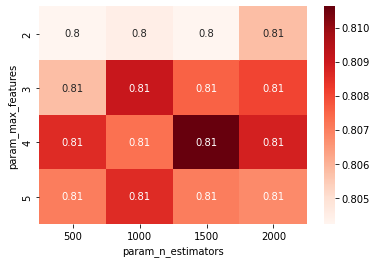

In [ ]:
wine = pd.read_csv("winequality-white.csv", sep=";")

X = wine[['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates','alcohol']].values
y = wine['quality'].values
y = (y >= 6).astype(np.int)
print(np.sum(y==1, axis=0))
print(np.sum(y==0, axis=0))

scaler = StandardScaler()
scaler.fit(X)
norm_X = scaler.transform(X)

# 主成分分析による次元削減（8次元に縮約）
norm_X = reduce_dimension(norm_X)

# 訓練データとテストデータに分割
norm_X_train, norm_X_test, y_train, y_test = train_test_split(norm_X, y, test_size=0.2, random_state=0, stratify=y) 

def model_selection3(X_train, y_train):
    param_grid = {"max_features": [2, 3, 4, 5], "n_estimators":[500, 1000, 1500, 2000]}
    grid = GridSearchCV(estimator=RandomForestClassifier(random_state=0), param_grid=param_grid, scoring="accuracy", cv=3)
    grid.fit(X_train, y_train)
    return grid.best_params_['max_features'], grid.best_params_['n_estimators'], grid.best_score_, grid.cv_results_

optimal_feature, optimal_estimator, valid_accuracy, cv_result = model_selection3(norm_X_train, y_train)

# GridSearchCV 結果の可視化
cv_result = pd.DataFrame(cv_result)
cv_result = cv_result[['param_max_features', 'param_n_estimators', 'mean_test_score']]
cv_result_pivot_table = cv_result.pivot_table('mean_test_score', 'param_max_features', 'param_n_estimators')
heatmap = sns.heatmap(cv_result_pivot_table, cmap='Reds', annot=True)

最適な決定木の数は1500、決定木の深さは4であることが分かった。この決定木の数と決定木の深さでランダムフォレストモデルを学習させ、テストデータによる評価を行う。

In [ ]:
rfc = RandomForestClassifier(random_state=0, max_features=4, n_estimators=1500)
rfc.fit(norm_X_train, y_train)
y_pred = rfc.predict(norm_X_test)

print(confusion_matrix(y_test, y_pred))  # 混同行列
print(accuracy_score(y_test, y_pred))  # accuracy
print(precision_score(y_test, y_pred))  # precision
print(recall_score(y_test, y_pred))  # recall
print(f1_score(y_test, y_pred))  # f値

[[220 108]
 [ 54 598]]
0.8346938775510204
0.8470254957507082
0.9171779141104295
0.8807069219440353


最終的なaccuracy は83%となった。